In [2]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

plt.style.use("bmh")
%matplotlib inline

In [3]:
def calculate_spec_prod_costs(n):
    """Takes a solved sector-coupled PyPSA network and outputs specific productio costs for one kg hydrogen at export nodes"""
    h2_prod_ex = n.links_t["p0"].filter(
        like="H2 export"
    )  # Amounts of H2 produced and provided for export
    h2_prod_ex.columns = h2_prod_ex.columns.str.strip(
        " export"
    )  # Modify column names to match with MP dataframe
    marginal_prices = n.buses_t.marginal_price.loc[
        :, h2_prod_ex.columns
    ]  # Marginal H2 prices at export nodes
    prod_costs = (h2_prod_ex * marginal_prices).sum(
        axis=0
    )  # Product of production ampunts and prices yields total production costs for each export node
    spec_prod_costs = prod_costs / h2_prod_ex.sum(
        axis=0
    )  # Division by total nodal production amount yields specific production costs of hydrogen for each export node
    spec_prod_costs = (
        spec_prod_costs * 33.3 / 1000
    )  # Calculate costs per kg assuming 1 kg H2 equals 33.3 KWh
    return spec_prod_costs

In [4]:
# run = 'ZZZZZ_363_normal_MCs_incl_ror'
run = "FINAL_5"
clusters = {"NZ": 122, "AP": 121, "BS": 120}
i_rate = {
    "BS": {2030: 0.175, 2050: 0.175},
    "AP": {2030: 0.076, 2050: 0.086},
    "NZ": {2030: 0.071, 2050: 0.045},
}
ns = {}
marginal_prices = pd.DataFrame()
normalized_costs = pd.DataFrame()
# for year in ['2030', '2050']:
for year in [2030]:
    for s in ["BS", "AP", "NZ"]:
        # for s in ['AP']:#, 'AP', 'NZ']:
        # system_costs = pd.read_csv('/home/cas96273/Thesis_Code/pypsa-earth-sec/results/{}/csvs/metrics_{}_{}.csv'.format(run, s, year), index_col=0).loc[['export', 'total costs']].T
        system_costs_no_exports = 0
        if year == 2030:
            ex_quantities = [0, 1, 10, 50, 100, 200, 500, 800, 1000]
            # ex_quantities = [0, 1, 10, 50, 1000]
        else:
            ex_quantities = [0, 10, 100, 500, 3000]
        # for export in ex_quantities[1:]:
        for export in ex_quantities:
            # i_rate = {'BS': {2030:0.175, 2050:0.175}, 'AP':{2030:0.076, 2050:0.086}, 'NZ':{2030:0.071, 2050:0.045}}
            n_s_y_e = pypsa.Network(
                "/nfs/home/haz43975/BR/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_3H_{}_{}_{}_{}export.nc".format(
                    run, clusters[s], year, i_rate[s][year], s, export
                )
            )
            ns[
                "n_{0}_{1}_{2}_{3}".format(year, i_rate[s][year], s, export)
            ] = n_s_y_e.copy()
            system_costs_e = n_s_y_e.objective
            if export == 0:
                system_costs_no_exports = system_costs_e
            hydrogen_costs = (
                (system_costs_e - system_costs_no_exports) / (export * 1e9) * 33.3
            )
            nc_n = pd.DataFrame(
                data={
                    "year": [year],
                    "scenario": [s],
                    "export_quantity": [export],
                    "system_costs": [system_costs_e],
                    "hydrogen_costs": [hydrogen_costs],
                }
            )
            normalized_costs = pd.concat([normalized_costs, nc_n])

            # i_rate = {'BS': {2030:0.175, 2050:0.175}, 'AP':{2030:0.076, 2050:0.086}, 'NZ':{2030:0.071, 2050:0.045}}
            # n_s_y_e = pypsa.Network("/home/cas96273/Thesis_Code/pypsa-earth-sec/results/{}/postnetworks/elec_s_{}_ec_lc1.0_Co2L_3H_{}_{}_{}_{}export.nc".format(run, clusters, year, i_rate[s][year],s, export))
            spec_prod_costs = calculate_spec_prod_costs(n_s_y_e)
            for node, price in spec_prod_costs.items():
                mp_n = pd.DataFrame(
                    data={
                        "year": [year],
                        "scenario": [s],
                        "export_quantity": [export],
                        "node": [node],
                        "marginal_price": [price],
                    }
                )
                marginal_prices = pd.concat([marginal_prices, mp_n])
n_check = ns["n_2030_0.175_BS_500"]
normalized_costs.fillna(0)

INFO:pypsa.io:Imported network elec_s_120_ec_lc1.0_Co2L_3H_2030_0.175_BS_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/tmp/ipykernel_1456104/4114683404.py:27: RuntimeWarning: invalid value encountered in double_scalars
  hydrogen_costs = (system_costs_e - system_costs_no_exports) / (export*1e9) * 33.3
INFO:pypsa.io:Imported network elec_s_120_ec_lc1.0_Co2L_3H_2030_0.175_BS_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_120_ec_lc1.0_Co2L_3H_2030_0.175_BS_10export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_120_ec_lc1.0_Co2L_3H_2030_0.175_BS_50export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_120_ec_lc1.0_Co2L_3H_2030_0.175_BS_100export.nc has bus

,year,scenario,export_quantity,system_costs,hydrogen_costs
0,2030,BS,0,8.120830e+10,0.000000
0,2030,BS,1,8.122437e+10,0.535301
0,2030,BS,10,8.199200e+10,2.609725
0,2030,BS,50,8.612973e+10,3.277676
0,2030,BS,100,9.210709e+10,3.629299
0,2030,BS,200,1.056868e+11,4.075669
0,2030,BS,500,1.476557e+11,4.425396
0,2030,BS,800,1.915011e+11,4.590936
0,2030,BS,1000,2.214685e+11,4.670665
0,2030,AP,0,7.926705e+10,0.000000


In [115]:
normalized_costs.to_csv("BR_2030_H2_costs.csv", index=0)

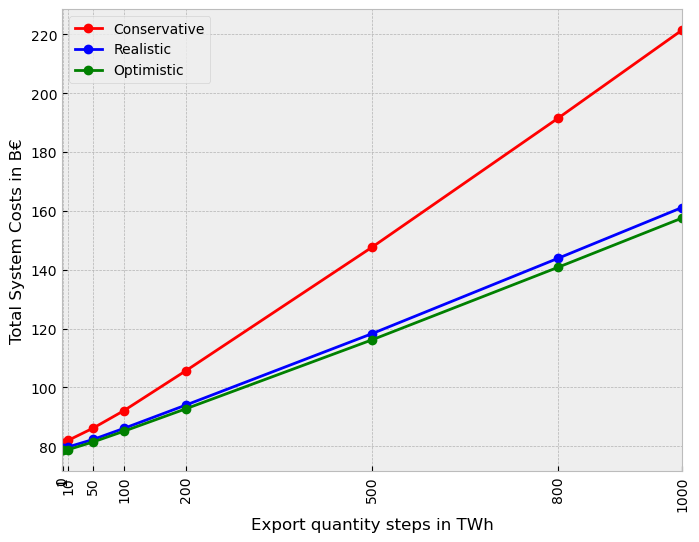

In [5]:
for y in normalized_costs.year.unique():
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 6)
    costs_y = normalized_costs.loc[normalized_costs.year == y]
    color_dict = {"BS": "red", "AP": "blue", "NZ": "green"}
    scen_dict = {"BS": "Conservative", "AP": "Realistic", "NZ": "Optimistic"}
    for s in normalized_costs.scenario.unique():
        costs_y_s = costs_y.loc[costs_y.scenario == s]

        # ax.fill_between(min.export_quantity, min.price, max.price, alpha=.3)
        ax.plot(
            costs_y_s.export_quantity,
            costs_y_s.system_costs / 1e9,
            label=scen_dict[s],
            color=color_dict[s],
            marker="o",
        )

    ax.set_xlabel("Export quantity steps in TWh")
    ax.set_ylabel("Total System Costs in B€")
    ax.set_xticks(costs_y_s.export_quantity)
    ax.set_xticklabels(costs_y_s.export_quantity, rotation=45)
    if y == 2030:
        ax.set_xlim((0, 1000))
    else:
        ax.set_xlim((0, 3000))
    ax.legend()
    plt.xticks(rotation=90)
    # plt.savefig('/nfs/home/haz43975/BR/pypsa-earth-sec/outputs/h2_normalized_costs_{}_{}.png'.format(run, str(y)))

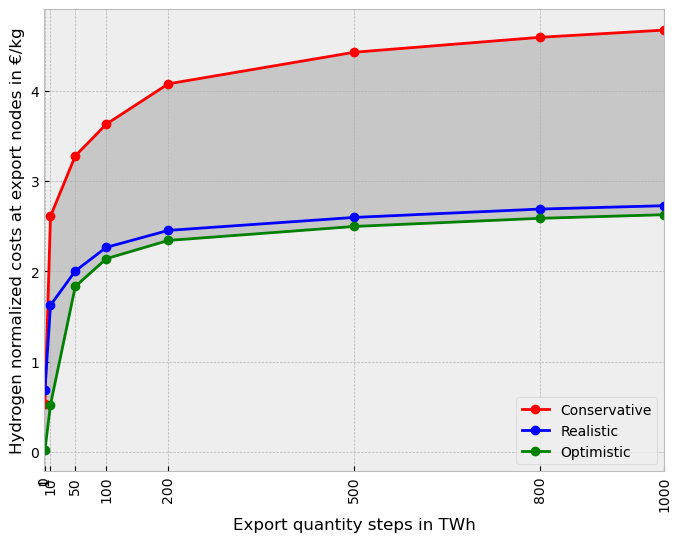

In [6]:
for y in normalized_costs.year.unique():
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 6)
    costs_y = normalized_costs.loc[normalized_costs.year == y]
    color_dict = {"BS": "red", "AP": "blue", "NZ": "green"}
    scen_dict = {"BS": "Conservative", "AP": "Realistic", "NZ": "Optimistic"}
    for s in normalized_costs.scenario.unique():
        costs_y_s = costs_y.loc[costs_y.scenario == s]

        # ax.fill_between(min.export_quantity, min.price, max.price, alpha=.3)
        ax.plot(
            costs_y_s.export_quantity,
            costs_y_s.hydrogen_costs,
            label=scen_dict[s],
            color=color_dict[s],
            marker="o",
        )

    ax.set_xlabel("Export quantity steps in TWh")
    ax.set_ylabel("Hydrogen normalized costs at export nodes in €/kg")
    ax.set_xticks(costs_y_s.export_quantity)
    ax.set_xticklabels(costs_y_s.export_quantity, rotation=45)
    if y == 2030:
        ax.set_xlim((0, 1000))
    else:
        ax.set_xlim((0, 3000))
    ax.legend()
    plt.xticks(rotation=90)
    maxs = normalized_costs.groupby("export_quantity").max()["hydrogen_costs"].iloc[1:]
    mins = normalized_costs.groupby("export_quantity").min()["hydrogen_costs"].iloc[1:]
    plt.fill_between(
        costs_y_s.export_quantity.iloc[1:], mins, maxs, color="gray", alpha=0.35
    )
    plt.savefig(
        "/nfs/home/haz43975/BR/pypsa-earth-sec/outputs/h2_normalized_costs_{}_{}.png".format(
            run, str(y)
        )
    )

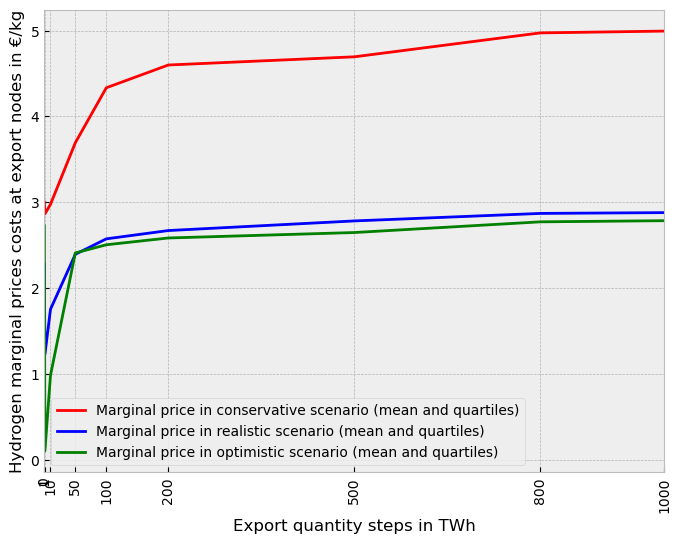

In [7]:
for y in marginal_prices.year.unique():
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 6)
    costs_y = marginal_prices.loc[marginal_prices.year == y]
    color_dict = {"BS": "red", "AP": "blue", "NZ": "green"}
    scen_dict = {"BS": "conservative", "AP": "realistic", "NZ": "optimistic"}
    for s in marginal_prices.scenario.unique():
        costs_y_s = costs_y.loc[costs_y.scenario == s]
        costs_y_s_des = (
            costs_y_s.drop("year", axis=1).groupby("export_quantity").describe()
        )
        min = costs_y_s.groupby("export_quantity", as_index=False).min(
            numeric_only=True
        )
        median = costs_y_s.groupby("export_quantity", as_index=False).median(
            numeric_only=True
        )
        max = costs_y_s.groupby(["scenario", "export_quantity"], as_index=False).max(
            numeric_only=True
        )

        ax.fill_between(
            costs_y_s_des.index,
            costs_y_s_des[("marginal_price", "25%")],
            costs_y_s_des[("marginal_price", "75%")],
            color=color_dict[s],
            alpha=0.2,
        )
        ax.plot(
            costs_y_s_des.index,
            costs_y_s_des[("marginal_price", "mean")],
            label="Marginal price in {} scenario (mean and quartiles)".format(
                scen_dict[s]
            ),
            color=color_dict[s],
        )

        # ax.fill_between(min.export_quantity, min.marginal_price, max.marginal_price, color=color_dict[s], alpha=.2)
        # ax.plot(min.export_quantity, min.marginal_price, label=s+' lowest costs', color=color_dict[s])

        # ax.plot(max.export_quantity, max.marginal_price, label=s+' highest costs', linestyle='dashed', color=color_dict[s])

    ax.set_xlabel("Export quantity steps in TWh")
    ax.set_ylabel("Hydrogen marginal prices costs at export nodes in €/kg")
    ax.set_xticks(costs_y_s_des.index)

    if y == 2030:
        ax.set_xlim((0, 1000))
    else:
        ax.set_xlim((0, 3000))
    plt.xticks(rotation=90)
    ax.legend()
    plt.savefig(
        "/nfs/home/haz43975/BR/pypsa-earth-sec/outputs/h2_mp_{}_{}.png".format(
            run, str(y)
        )
    )



Highest mean electricity price in BR.21_1_AC


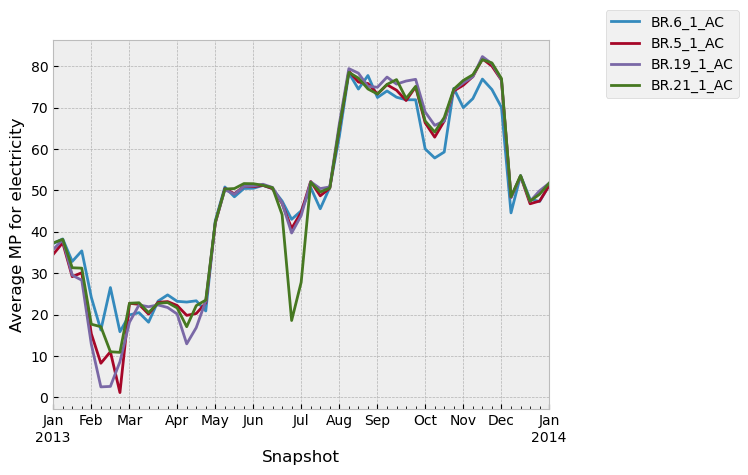

In [8]:
def plot_elec_mps(n, sample_rate="W", only_export=True):
    links = n.links
    buses_t = n.buses_t

    if only_export:
        exp_h2_links = n.links.loc[links.bus1 == "H2 export bus"].index.str.rstrip(
            " H2 export"
        )
        mp_ts = buses_t.marginal_price[exp_h2_links]
    else:
        mp_ts = buses_t.marginal_price.filter(regex="_AC$")
    mp_ts = mp_ts.resample(sample_rate).mean()
    fig, ax = plt.subplots(1, 1)

    mp_ts.plot(ax=ax).legend(bbox_to_anchor=(1.1, 1.1))

    ax.set_ylabel("Average MP for electricity")
    ax.set_xlabel("Snapshot")
    print(
        "\n\nHighest mean electricity price in {}".format(
            mp_ts.mean().sort_values(ascending=False).idxmax()
        )
    )


plot_elec_mps(n_check)



Highest mean hydrogen price in BR.23_1_AC H2


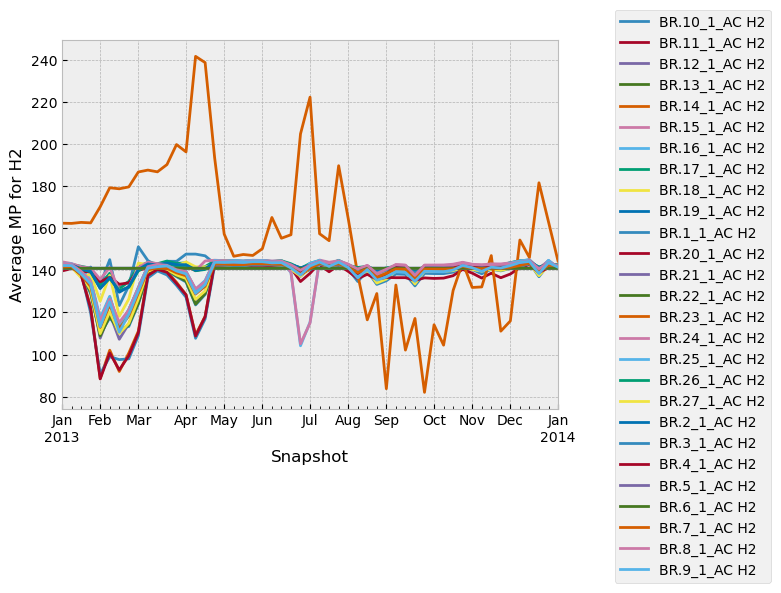

In [9]:
def plot_h2_mps(n, sample_rate="W", only_export=True, include_export_bus=False):
    links = n.links
    buses_t = n.buses_t

    if only_export:
        exp_h2_links = n.links.loc[links.bus1 == "H2 export bus"].index.str.rstrip(
            " export"
        )

        # if include_export_bus:
        exp_bus = n.links.loc[links.bus2 == "H2 export bus"].index
        mp_ts = buses_t.marginal_price[exp_h2_links]
    else:
        mp_ts = buses_t.marginal_price.filter(regex="H2$")
    mp_ts = mp_ts.resample(sample_rate).mean()
    fig, ax = plt.subplots(1, 1)

    mp_ts.plot(ax=ax).legend(bbox_to_anchor=(1.1, 1.1))

    ax.set_ylabel("Average MP for H2")
    ax.set_xlabel("Snapshot")
    print(
        "\n\nHighest mean hydrogen price in {}".format(
            mp_ts.mean().sort_values(ascending=False).idxmax()
        )
    )


plot_h2_mps(n_check, only_export=False)



Highest H2 production quantity in BR.5_1_AC H2 Electrolysis


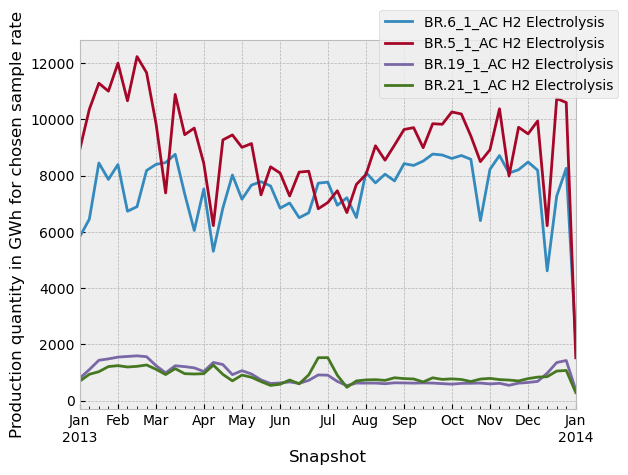

In [10]:
def plot_h2_production(n, sample_rate="W"):
    links = n.links
    links_t = n.links_t

    exp_h2_links = (
        n.links.loc[links.bus1 == "H2 export bus"].index.str.rstrip("export")
        + "Electrolysis"
    )
    exp_h2_links_prod_ts = (
        links_t.p1[exp_h2_links] * -n.snapshot_weightings.iloc[0, 0] / 1e3
    )
    exp_h2_links_prod_ts = exp_h2_links_prod_ts.resample(sample_rate).sum()

    fig, ax = plt.subplots(1, 1)

    exp_h2_links_prod_ts.plot(ax=ax).legend(bbox_to_anchor=(1.1, 1.1))

    ax.set_ylabel("Production quantity in GWh for chosen sample rate")
    ax.set_xlabel("Snapshot")
    print(
        "\n\nHighest H2 production quantity in {}".format(
            exp_h2_links_prod_ts.sum().sort_values(ascending=False).idxmax()
        )
    )


plot_h2_production(ns["n_2030_0.071_NZ_1000"])



Highest H2 delivery from BR.5_1_AC H2 export


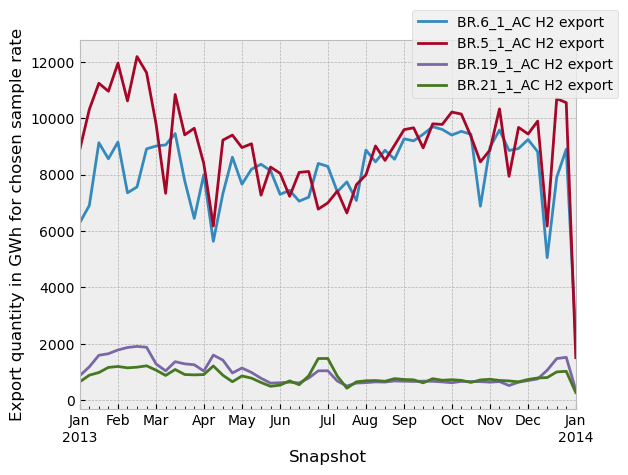

In [11]:
def plot_h2_exports(n, sample_rate="W"):
    links = n.links
    links_t = n.links_t

    exp_h2_links = n.links.loc[links.bus1 == "H2 export bus"]
    exp_h2_links_ts = (
        links_t.p0[exp_h2_links.index] * n.snapshot_weightings.iloc[0, 0] / 1e3
    )
    exp_h2_links_ts = exp_h2_links_ts.resample(sample_rate).sum()

    fig, ax = plt.subplots(1, 1)

    exp_h2_links_ts.plot(ax=ax).legend(bbox_to_anchor=(1.1, 1.1))

    ax.set_ylabel("Export quantity in GWh for chosen sample rate")
    ax.set_xlabel("Snapshot")
    print(
        "\n\nHighest H2 delivery from {}".format(
            exp_h2_links_ts.sum().sort_values(ascending=False).idxmax()
        )
    )


plot_h2_exports(ns["n_2030_0.071_NZ_1000"])

In [12]:
def calc_expansion(n, carrier=None):
    """""" "in MW" """"""
    gens = n.generators.groupby("carrier").sum()
    inv_gens = gens.p_nom_opt - gens.p_nom

    links = n.links.groupby("carrier").sum()
    inv_links = links.p_nom_opt - links.p_nom

    stores = n.stores.groupby("carrier").sum()
    inv_stores = stores.e_nom_opt - stores.e_nom

    # storages = n.storage_units.groupby('carrier').sum()
    # inv_storages = storages.e_nom_opt - storages.e_nom

    inv = pd.concat([inv_gens, inv_links, inv_stores])

    if carrier != None:
        try:
            inv = inv.loc[carrier]
        except:
            print("carrier not existing")
    return inv


exp = calc_expansion(n_check)

(exp.sort_values(ascending=False) / 1e3).head(10)

/tmp/ipykernel_1456104/2242214322.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gens = n.generators.groupby('carrier').sum()
/tmp/ipykernel_1456104/2242214322.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  links = n.links.groupby('carrier').sum()
/tmp/ipykernel_1456104/2242214322.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stores = n.stores.groupby('carrier').sum()


carrier
gas                           1.698148e+09
oil                           2.699998e+08
H2                            1.567761e+07
co2                           3.201061e+05
solar                         5.223792e+02
H2 Electrolysis               2.002450e+02
H2                            1.344227e+02
OCGT                          7.799111e+01
gas                           6.417552e+01
solid biomass for industry    3.670945e+01
dtype: float64

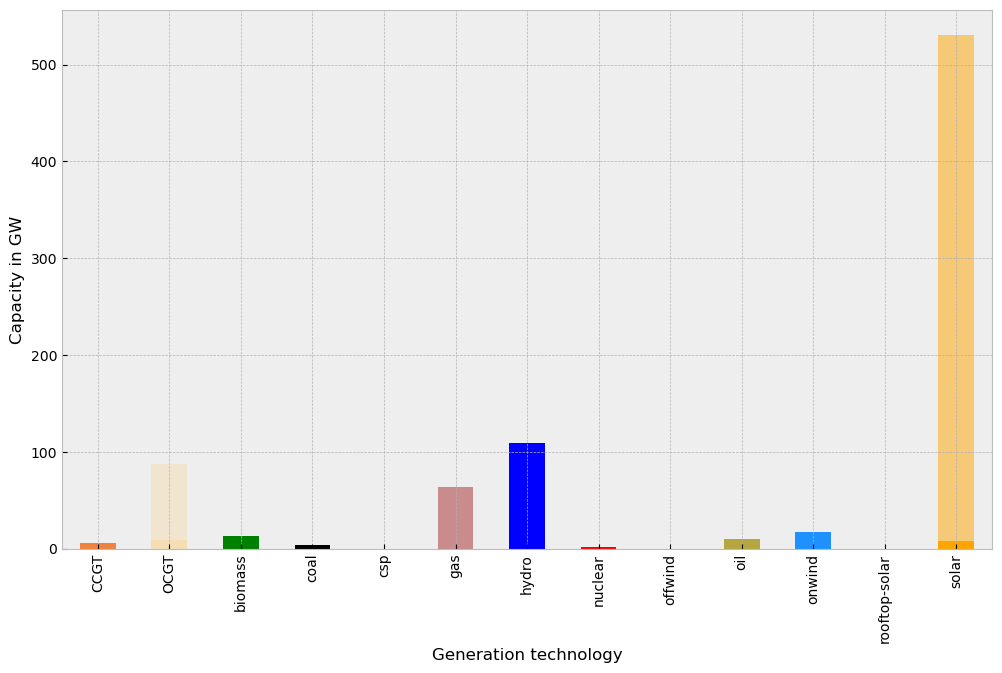

In [13]:
def plot_expansion(n):
    color_dict = {
        "CCGT": "#ee8340",
        "biomass": "green",
        "coal": "k",
        "oil": "#B5A642",
        "onwind": "dodgerblue",
        "offwind": "#6895dd",
        "solar": "orange",
        "rooftop-solar": "#ffef60",
        "OCGT": "wheat",
        "hydro": "b",
        "nuclear": "r",
        "gas": "brown",
        "residential rural solar thermal": "coral",
        "services rural solar thermal": "coral",
        "residential urban decentral solar thermal": "coral",
        "services urban decentral solar thermal": "coral",
        "urban central solar thermal": "coral",
        "csp": "coral",
    }

    gens = n.generators
    gens.loc[gens.carrier.str.contains("solar thermal"), "carrier"] = "csp"
    gens.loc[gens.carrier.str.contains("solar thermal"), "carrier"] = "csp"
    gens.loc[gens.carrier.str.contains("offwind"), "carrier"] = "offwind"
    gens.loc[gens.carrier.str.contains("onwind"), "carrier"] = "onwind"
    gen_grouped = gens.groupby("carrier", as_index=False).sum(numeric_only=True)

    OCGT_exp = n.links.filter(like="OCGT", axis=0).sum().p_nom_opt
    gen_grouped.loc[gen_grouped.carrier == "OCGT", "p_nom_opt"] = (
        gen_grouped.loc[gen_grouped.carrier == "OCGT", "p_nom"] + OCGT_exp
    )

    stors = n.storage_units
    stors_grouped = stors.groupby("carrier", as_index=False).sum(numeric_only=True)

    techs = pd.concat(
        [
            gen_grouped.set_index("carrier")[["p_nom", "p_nom_opt"]].divide(1e3),
            stors_grouped.set_index("carrier")[["p_nom", "p_nom_opt"]].divide(1e3),
        ]
    )
    techs.loc["hydro"] = techs.loc["hydro"] + techs.loc["ror"]
    techs.drop("ror", inplace=True)
    techs["color"] = techs.reset_index().carrier.apply(lambda c: color_dict[c]).values
    techs.sort_index(inplace=True)

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 7)
    techs.p_nom_opt.plot.bar(ax=ax, color=techs.color, alpha=0.5)
    techs.p_nom.plot.bar(ax=ax, color=techs.color)

    ax.set_xlabel("Generation technology")
    ax.set_ylabel("Capacity in GW")


plot_expansion(n_check)

In [14]:
preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "solid biomass",
        "biogas",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "solar PV",
        "solar thermal",
        "solar",
        "building retrofitting",
        "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "power-to-heat",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "helmeth",
        "methanation",
        "hydrogen storage",
        "power-to-gas",
        "power-to-liquid",
        "battery storage",
        "hot water storage",
        "CO2 sequestration",
    ]
)


def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        "H2": "hydrogen storage",
        "battery": "battery storage",
        "CCS": "CCS",
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "onwind": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label


def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    elif tech in ["methanation", "hydrogen storage", "helmeth"]:
        return "power-to-gas"
    elif tech in ["OCGT", "CHP", "gas boiler"]:
        return "gas-to-power/heat"
    elif "solar" in tech:
        return "solar"
    elif tech == "Fischer-Tropsch":
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    else:
        return tech


def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)

        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue

            names = ifind.index[ifind == i]

            c.df.loc[names, "location"] = names.str[:i]

In [15]:
def calc_cost(network, cost_type="capital", expansion=True):
    n = network.copy()
    assign_location(n)
    # Drop non-electric buses so they don't clutter the plot
    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    costs = pd.DataFrame(index=n.buses.index)
    components = [
        "links",
        "generators",
        "stores",
        "storage_units",
    ]  # TODO uncomment after adding storage units
    for comp in components:
        df_c = getattr(n, comp)  #

        df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

        attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"
        attr_nom = "e_nom" if comp == "stores" else "p_nom"

        if cost_type == "capital":
            if expansion == True:
                costs_c = (
                    (df_c.capital_cost * (df_c[attr] - df_c[attr_nom]))
                    .groupby([df_c.location, df_c.nice_group])
                    .sum()
                    .unstack()
                    .fillna(0.0)
                )
            else:
                costs_c = (
                    (df_c.capital_cost * df_c[attr])
                    .groupby([df_c.location, df_c.nice_group])
                    .sum()
                    .unstack()
                    .fillna(0.0)
                )
        else:  # cost_type == "marginal":
            df_t = {
                "links": n.links_t,
                "generators": n.generators_t,
                "stores": n.stores_t,
                "storage_units": n.storage_units_t,
            }
            attr = "p0" if comp == "links" else "p"
            df_c_t = df_t[comp]

            costs_c = (
                # (df_c.marginal_cost * df_c_t[attr])
                (
                    df_c.marginal_cost
                    * (df_c_t[attr].T * n.snapshot_weightings.generators).T
                )
                # .groupby([df_c.location, df_c.nice_group])
                .sum()
                # .unstack()
                # .fillna(0.0)
            )

            # print(costs_c)
        costs = pd.concat([costs, costs_c], axis=1)

        # print(comp, costs)
    costs = costs.groupby(costs.columns, axis=1).sum()

    costs.drop(list(costs.columns[(costs == 0.0).all()]), axis=1, inplace=True)

    new_columns = preferred_order.intersection(costs.columns).append(
        costs.columns.difference(preferred_order)
    )
    costs = costs[new_columns]

    # for item in new_columns:
    #    if item not in tech_colors:
    #        print("Warning!", item, "not in config/plotting/tech_colors")

    # costs = costs.stack()

    return costs  # .sort_index()


n_check = ns["n_2030_0.071_NZ_500"]
n_0_AP_CC = calc_cost(n_check, cost_type="capital", expansion=True)
n_0_AP_MC = calc_cost(n_check, cost_type="marginal", expansion=True)

In [16]:
(n_0_AP_CC.sum().sum() + n_0_AP_MC.sum().sum()) / 1e10

11.616013248741806

In [61]:
year = 2030
sc = "AP"
ir = i_rate[sc][year]
qs = ["1", "10", "50", "100", "200", "500", "800", "1000"]
qs = ["1", "50", "100", "200", "1000"]
# n_check = ns["n_2030_0.076_AP_200"]

In [62]:
tech_colors = {
    0: "black",
    " oil Store": "yellow",
    "SMR CC": "darkblue",
    "csp": "gold",
    "gas for industry CC": "brown",
    "process emissions CC": "gray",
    "CO2 pipeline": "gray",
    "onwind": "dodgerblue",
    "onwind2": "dodgerblue",
    "onshore wind": "#235ebc",
    "offwind": "#6895dd",
    "offwind2": "#6895dd",
    "offshore wind": "#6895dd",
    "offwind-ac": "c",
    "offshore wind (AC)": "#6895dd",
    "offwind-dc": "#74c6f2",
    "offshore wind (DC)": "#74c6f2",
    "wave": "#004444",
    "hydro": "#3B5323",
    "hydro reservoir": "#3B5323",
    "ror": "#78AB46",
    "run of river": "#78AB46",
    "hydroelectricity": "blue",
    "solar": "orange",
    "solar PV": "#f9d002",
    "solar thermal": "coral",
    "solar rooftop": "#ffef60",
    "OCGT": "wheat",
    "OCGT marginal": "sandybrown",
    "OCGT-heat": "#ee8340",
    "gas boiler": "#ee8340",
    "gas boilers": "#ee8340",
    "gas boiler marginal": "#ee8340",
    "gas-to-power/heat": "brown",
    "gas": "brown",
    "natural gas": "brown",
    "SMR": "#4F4F2F",
    "oil": "#B5A642",
    "oil boiler": "#B5A677",
    "lines": "k",
    "transmission lines": "k",
    "H2": "m",
    "H2 liquefaction": "m",
    "hydrogen storage": "m",
    "battery": "slategray",
    "battery storage": "slategray",
    "home battery": "#614700",
    "home battery storage": "#614700",
    "Nuclear": "r",
    "Nuclear marginal": "r",
    "nuclear": "r",
    "uranium": "r",
    "Coal": "k",
    "coal": "k",
    "Coal marginal": "k",
    "Lignite": "grey",
    "lignite": "grey",
    "Lignite marginal": "grey",
    "CCGT": "#ee8340",
    "CCGT marginal": "#ee8340",
    "heat pumps": "#76EE00",
    "heat pump": "#76EE00",
    "air heat pump": "#76EE00",
    "ground heat pump": "#40AA00",
    "power-to-heat": "red",
    "resistive heater": "pink",
    "Sabatier": "#FF1493",
    "methanation": "#FF1493",
    "power-to-gas": "purple",
    "electrolysis": "purple",
    "power-to-liquid": "darkgreen",
    "helmeth": "#7D0552",
    "DAC": "deeppink",
    "co2 stored": "#123456",
    "CO2 sequestration": "#123456",
    "CC": "k",
    "co2": "#123456",
    "co2 vent": "#654321",
    "agriculture heat": "#D07A7A",
    "agriculture machinery oil": "#1e1e1e",
    "agriculture machinery oil emissions": "#111111",
    "agriculture electricity": "#222222",
    "solid biomass for industry co2 from atmosphere": "#654321",
    "solid biomass for industry co2 to stored": "#654321",
    "solid biomass for industry CC": "#654321",
    "gas for industry co2 to atmosphere": "#654321",
    "gas for industry co2 to stored": "#654321",
    "Fischer-Tropsch": "#44DD33",
    "kerosene for aviation": "#44BB11",
    "naphtha for industry": "#44FF55",
    "land transport oil": "#44DD33",
    "water tanks": "#BBBBBB",
    "hot water storage": "#BBBBBB",
    "hot water charging": "#BBBBBB",
    "hot water discharging": "#999999",
    # CO2 pipeline: '#999999'
    "CHP": "r",
    "CHP heat": "r",
    "CHP electric": "r",
    "PHS": "g",
    "Ambient": "k",
    "Electric load": "b",
    "Heat load": "r",
    "heat": "darkred",
    "rural heat": "#880000",
    "central heat": "#b22222",
    "decentral heat": "#800000",
    "low-temperature heat for industry": "#991111",
    "process heat": "#FF3333",
    "heat demand": "darkred",
    "electric demand": "k",
    "Li ion": "grey",
    "district heating": "#CC4E5C",
    "retrofitting": "purple",
    "building retrofitting": "purple",
    "BEV charger": "grey",
    "V2G": "grey",
    "land transport EV": "grey",
    "electricity": "k",
    "gas for industry": "#333333",
    "solid biomass for industry": "#555555",
    "industry electricity": "#222222",
    "industry new electricity": "#222222",
    "process emissions to stored": "#444444",
    "process emissions to atmosphere": "#888888",
    "process emissions": "#222222",
    "oil emissions": "#666666",
    "industry oil emissions": "#666666",
    "land transport oil emissions": "#666666",
    "land transport fuel cell": "#AAAAAA",
    "biogas": "#800000",
    "solid biomass": "#DAA520",
    "today": "#D2691E",
    "shipping": "#6495ED",
    "shipping oil": "#6495ED",
    "shipping oil emissions": "#6495ED",
    "electricity distribution grid": "y",
    "solid biomass transport": "green",
    "biomass EOP": "green",
    "H2 for industry": "#222222",
    "H2 for shipping": "#6495ED",
    "other": "grey",
    "biomass": "green",
}


def plot_capital_costs(base_ncost, ncosts, ex_qs, scenario):
    ss = pd.DataFrame()
    for i, ncost in enumerate(ncosts):
        cc_diff = (ncosts[i] - base_ncost).sum()

        ss[ex_qs[i]] = cc_diff

    ss_temp = ss.abs().sort_values(by="1", ascending=False)
    ss = ss.sort_values(by="1", ascending=False)
    chosen = ss_temp.index[:6]
    to_plot = ss.loc[chosen].copy()
    to_plot.rename(
        index={"onwind2": "onshore wind", "power-to-gas": "electrolysis"}, inplace=True
    )
    to_plot = to_plot.groupby(to_plot.index).sum().sort_values(by="1", ascending=False)

    other = pd.Series(ss.loc[~ss.index.isin(chosen)].sum(), name="other")
    plot_this = to_plot.append(other)
    for column in plot_this:
        plot_this[column] = plot_this[column] / (eval(column) * 1e9) * 33.3 * 100
    ax = plot_this.T.plot.bar(
        stacked=True,
        color=tech_colors,
        rot=0,
        zorder=3,
        title="Brazil: {} Scenario 2030".format(scenario),
        figsize=(9, 5.5),
    )

    plt.xlabel("Green H2 quantity to export [TWh]")
    plt.ylabel("Cost components (capital costs) of normalized cost of H2\n [c€/kg]")

    for x, y in enumerate(round(plot_this.sum(axis=0), 1)):
        ax.annotate(y, (x, y + 5e2), ha="center")

    ax.margins(y=0.1)
    plt.grid(zorder=0)
    plt.savefig("HYPAT_Figures/Overall_BR2030_{}.png".format(scenario))
    plt.legend()
    plt.show()
    return plot_this

/tmp/ipykernel_1456104/4115693979.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_this=(to_plot.append(other))


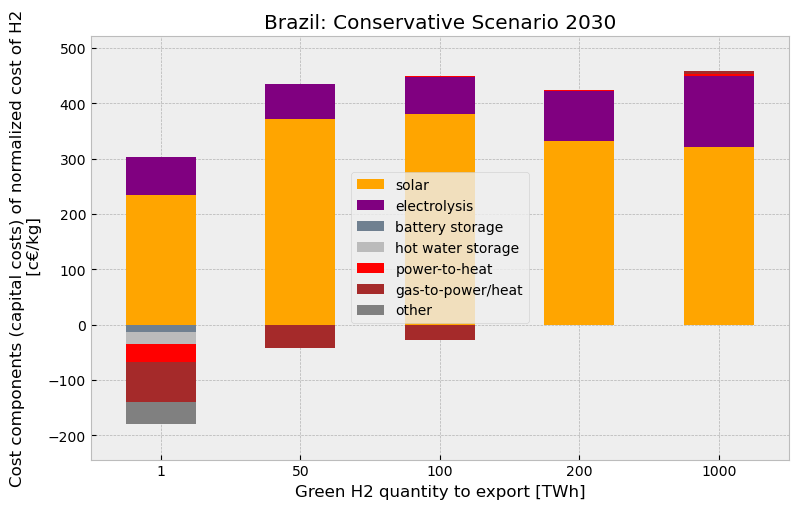

/tmp/ipykernel_1456104/4115693979.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_this=(to_plot.append(other))


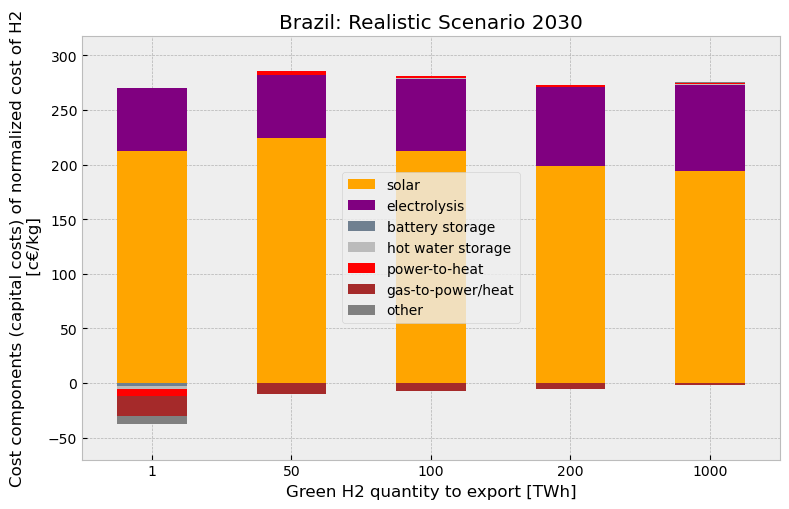

/tmp/ipykernel_1456104/4115693979.py:163: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_this=(to_plot.append(other))


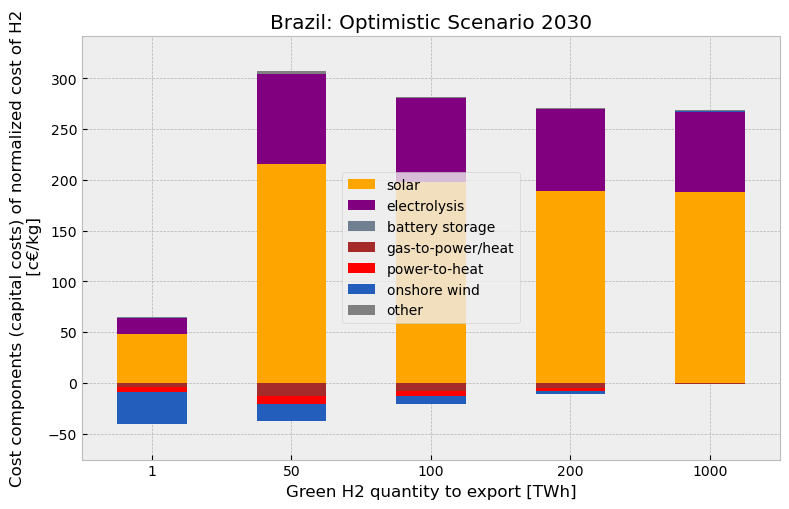

In [65]:
# CONSERVATIVE
year = 2030
sc = "BS"
ir = i_rate[sc][year]
base_cost = calc_cost(
    ns["n_{0}_{1}_{2}_0".format(year, ir, sc)], cost_type="capital", expansion=False
)
capital_costs = []
for q in qs:
    capital_costs.append(
        calc_cost(
            ns["n_{0}_{1}_{2}_{3}".format(year, ir, sc, q)],
            cost_type="capital",
            expansion=False,
        )
    )

cc_cc = plot_capital_costs(base_cost, capital_costs, qs, "Conservative")
cc_cc.to_csv("HYPAT_Figures/n_{0}_{1}_{2}_{3}.csv".format(year, ir, sc, q))


# REALISTIC

year = 2030
sc = "AP"
ir = i_rate[sc][year]
base_cost = calc_cost(
    ns["n_{0}_{1}_{2}_0".format(year, ir, sc)], cost_type="capital", expansion=False
)
capital_costs = []
for q in qs:
    capital_costs.append(
        calc_cost(
            ns["n_{0}_{1}_{2}_{3}".format(year, ir, sc, q)],
            cost_type="capital",
            expansion=False,
        )
    )

cc_cc = plot_capital_costs(base_cost, capital_costs, qs, "Realistic")
cc_cc.to_csv("HYPAT_Figures/n_{0}_{1}_{2}_{3}.csv".format(year, ir, sc, q))

# OPTIMISTIC

year = 2030
sc = "NZ"
ir = i_rate[sc][year]
base_cost = calc_cost(
    ns["n_{0}_{1}_{2}_0".format(year, ir, sc)], cost_type="capital", expansion=False
)
capital_costs = []
for q in qs:
    capital_costs.append(
        calc_cost(
            ns["n_{0}_{1}_{2}_{3}".format(year, ir, sc, q)],
            cost_type="capital",
            expansion=False,
        )
    )

cc_cc = plot_capital_costs(base_cost, capital_costs, qs, "Optimistic")
cc_cc.to_csv("HYPAT_Figures/n_{0}_{1}_{2}_{3}.csv".format(year, ir, sc, q))

In [66]:
def calc_marginal_costs(base_ncost, ncosts, ex_qs, scenario):
    # global grouped

    ss = pd.DataFrame()
    # plt.figure()

    for i, ncost in enumerate(ncosts):
        delta_marginalcost = ncost - base_ncost
        # delta_marginalcost= (n10c_costs_m - n0c_costs_m)

        grouped = delta_marginalcost.groupby(delta_marginalcost.index.str[10:])[0].sum()
        # print(grouped)

        # print(grouped.sort_values(ascending=False).iloc[-5:])
        # grouped.sort_values(ascending=False).iloc[-5:].T.plot.bar(stacked=True)
        ss[ex_qs[i]] = grouped

    ss = ss.sort_values(by="1", ascending=False)
    chosen1 = ss.abs().sort_values(ascending=False, by="1")[:9].index
    chosen2 = ss.abs().sort_values(ascending=False, by="1000")[:9].index
    # chosen=np.append(ss.index[:2], ss.index[-2:])
    chosen = chosen1.union(chosen2)
    to_plot = ss.loc[chosen].copy()
    to_plot.rename(
        index={
            "onwind2": "onshore wind",
            "H2 Electrolysis": "electrolysis",
            " gas": "gas",
            "OCGT": "gas",
            " OCGT": "gas",
            "CCGT": "gas",
            " CCGT": "gas",
            " coal": "coal",
            "oil Store": "oil",
            " oil": "oil",
            " biomass": "biomass",
            " urban central gas CHP": "gas",
        },
        inplace=True,
    )

    # print(to_plot.index)
    to_plot = to_plot.groupby(to_plot.index).sum().sort_values(by="50", ascending=False)

    other = pd.Series(ss.loc[~ss.index.isin(chosen)].sum(), name="other")
    # print(other)
    plot_this = to_plot.append(other)

    # plot_this.T.plot.bar(stacked=True, rot=0, zorder=3, title="Morocco: {} Scenario 2030".format(scenario), figsize=(9, 5.5))
    for column in plot_this:
        plot_this[column] = plot_this[column] / (eval(column) * 1e9) * 33.3 * 100

    ax = plot_this.sort_values(by="1", ascending=False).T.plot.bar(
        stacked=True, colormap="tab20", figsize=(9, 5.5)
    )  # ,color=tech_colors)
    ax.grid()
    ax.get_legend()
    plt.grid(zorder=0)
    plt.savefig("HYPAT_Figures/Overall_BR2030_mc_{}.png".format(scenario))
    plt.legend()
    # plt.legend(False)
    # plt.savefig("HYPAT_Figures/Marginal_MA2030_{}.png".format(scenario))
    return plot_this

/tmp/ipykernel_1456104/2541267447.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_this=(to_plot.append(other))
/tmp/ipykernel_1456104/2541267447.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_this=(to_plot.append(other))
/tmp/ipykernel_1456104/2541267447.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_this=(to_plot.append(other))


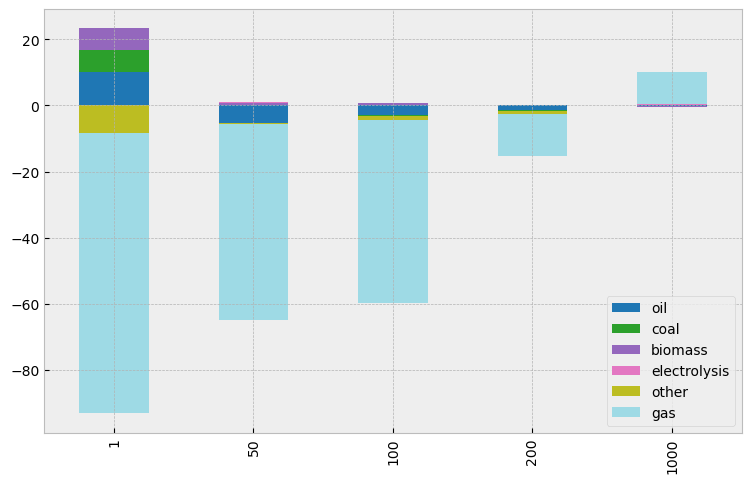

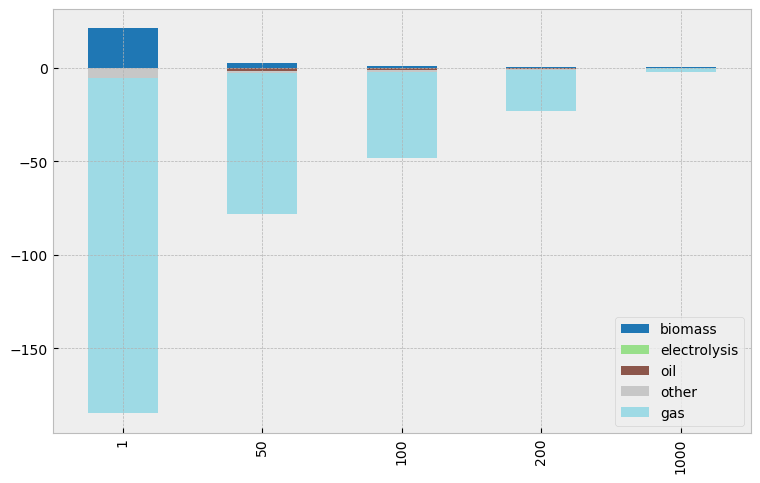

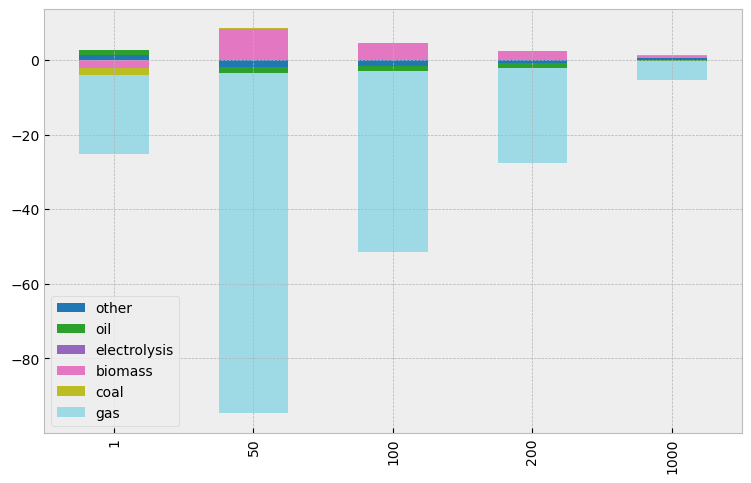

In [67]:
# CONSERVATIVE
year = 2030
sc = "BS"
ir = i_rate[sc][year]
base_cost = calc_cost(
    ns["n_{0}_{1}_{2}_0".format(year, ir, sc)], cost_type="marginal", expansion=False
)
capital_costs = []
for q in qs:
    capital_costs.append(
        calc_cost(
            ns["n_{0}_{1}_{2}_{3}".format(year, ir, sc, q)],
            cost_type="marginal",
            expansion=False,
        )
    )

cc_mc = calc_marginal_costs(base_cost, capital_costs, qs, "Conservative")
cc_mc.to_csv("HYPAT_Figures/n_{0}_{1}_{2}_{3}_mc.csv".format(year, ir, sc, q))


# REALISTIC

year = 2030
sc = "AP"
ir = i_rate[sc][year]
base_cost = calc_cost(
    ns["n_{0}_{1}_{2}_0".format(year, ir, sc)], cost_type="marginal", expansion=False
)
capital_costs = []
for q in qs:
    capital_costs.append(
        calc_cost(
            ns["n_{0}_{1}_{2}_{3}".format(year, ir, sc, q)],
            cost_type="marginal",
            expansion=False,
        )
    )

cc_mc = calc_marginal_costs(base_cost, capital_costs, qs, "Realistic")
cc_mc.to_csv("HYPAT_Figures/n_{0}_{1}_{2}_{3}_mc.csv".format(year, ir, sc, q))

# OPTIMISTIC

year = 2030
sc = "NZ"
ir = i_rate[sc][year]
base_cost = calc_cost(
    ns["n_{0}_{1}_{2}_0".format(year, ir, sc)], cost_type="marginal", expansion=False
)
capital_costs = []
for q in qs:
    capital_costs.append(
        calc_cost(
            ns["n_{0}_{1}_{2}_{3}".format(year, ir, sc, q)],
            cost_type="marginal",
            expansion=False,
        )
    )

cc_mc = calc_marginal_costs(base_cost, capital_costs, qs, "Optimistic")
cc_mc.to_csv("HYPAT_Figures/n_{0}_{1}_{2}_{3}_mc.csv".format(year, ir, sc, q))

In [ ]:
def get_fossil_emissions(n):
    """""" "in t" """"""
    AC_index = n.buses[n.buses.carrier == "AC"].index

    # vars_conv_gens = get_var(n, "Store", "e").loc[sns[-1], co2_atmosphere]
    conv_gens = list(n.carriers[n.carriers.co2_emissions > 0].index)
    conv_index = n.generators[n.generators.carrier.isin(conv_gens)].index
    # vars_conv_gens = n.generators_t.p[conv_index]
    convs = n.generators[n.generators.carrier.isin(conv_gens)]
    conv_index = convs[convs["bus"].isin(AC_index)].index

    conv_gen = (
        n.generators_t.p[conv_index].sum().sum()
        * n.snapshot_weightings.iloc[0, 0]
        / 1e6
    )
    print("\nFossil generation amounts to {} TWh".format(conv_gen))

    n.generators.loc[n.generators.carrier.isin(conv_gens), "emissions"] = 0
    n.generators.loc[conv_index, "emissions"] = n.generators.loc[
        conv_index, "carrier"
    ].apply(lambda x: n.carriers.loc[x].co2_emissions)
    n.generators.emissions = n.generators.emissions.fillna(0)

    weightings = pd.DataFrame(
        np.outer(n.snapshot_weightings["generators"], [1.0] * len(conv_index)),
        index=n.snapshots,
        columns=conv_index,
    )

    emission_factors = pd.DataFrame(
        np.outer(
            [1.0] * len(n.snapshot_weightings["generators"]),
            n.generators.loc[conv_index, "emissions"],
        ),
        index=n.snapshots,
        columns=conv_index,
    )

    return n.generators_t.p[conv_index], weightings, emission_factors, conv_index


def print_summary(n):
    print("The objective value of the network is {} Bn €".format(n.objective / 1e9))
    print("\nThe largest expansions are done for the following technologies: ")
    print(calc_expansion(n).sort_values().tail(20))

    gen, weightings, e_factors, conv_index = get_fossil_emissions(n)

    emissions_fossil_gen = gen * weightings * e_factors
    emissions_fossil_gen = emissions_fossil_gen.sum().sum() / 1e6

    emissions_links_loads = n.stores_t.e.filter(like="atmosphere").iloc[-1].item() / 1e6

    print(
        "\nThe final emissions in the atmosphere amount to {} Mt".format(
            emissions_fossil_gen + emissions_links_loads
        )
    )


n = pypsa.Network(
    "/nfs/home/haz43975/BR/pypsa-earth-sec/results/FINAL_3/postnetworks/elec_s_107_ec_lc1.0_Co2L_3H_2030_0.076_AP_200export.nc"
)
print_summary(n_check)

INFO:pypsa.io:Imported network elec_s_107_ec_lc1.0_Co2L_3H_2030_0.076_AP_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


The objective value of the network is 73.18985974851172 Bn €

The largest expansions are done for the following technologies: 
carrier
residential urban decentral water tanks charger    1.035462e+02
OCGT                                               1.177248e+02
battery                                            5.920618e+02
urban central gas boiler                           1.304814e+03
urban central water tanks                          3.144561e+03
process emissions                                  3.315446e+03
solid biomass transport                            5.105916e+03
urban central water tanks discharger               8.037436e+03
urban central water tanks charger                  9.811119e+03
gas for industry                                   1.015278e+04
gas                                                1.104018e+04
urban central resistive heater                     1.225147e+04
H2                                                 2.490532e+04
solid biomass for industry       

/tmp/ipykernel_1131201/2242214322.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gens = n.generators.groupby('carrier').sum()
/tmp/ipykernel_1131201/2242214322.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  links = n.links.groupby('carrier').sum()
/tmp/ipykernel_1131201/2242214322.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stores = n.stores.groupby('carrier').sum()


ValueError: too many values to unpack (expected 4)

In [120]:
def calc_generation(n, tech="all"):
    """""" "in TWh" """"""
    gen_t = n.generators_t.p.sum()
    gen_agg = pd.DataFrame(data={"bus": gen_t.index, "generation": gen_t.values})
    gen_agg["carrier"] = n.generators.loc[gen_agg.bus, "carrier"].values
    gen_agg = gen_agg.groupby("carrier").sum() / 1e6 * n.snapshot_weightings.iloc[0, 0]

    hydro_gen = n.storage_units_t.p.sum().sum() / 1e6 * n.snapshot_weightings.iloc[0, 0]
    gen_agg.loc["hydro"] = [hydro_gen]
    if tech == "all":
        return gen_agg
    else:
        return gen_agg.loc[tech]


calc_generation(n, "ror") / n.generators.loc[
    n.generators.carrier == "ror", "p_nom_opt"
].sum() / 8760 * 1e6

/tmp/ipykernel_1270995/3817854574.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_agg = gen_agg.groupby('carrier').sum() / 1e6 * n.snapshot_weightings.iloc[0,0]


generation    0.233753
Name: ror, dtype: float64